## Telecom Data Cup
Жалнин Андрей

Окончательный расчет с помощью одной модели LightGBM, основное - подготовка данных. На кроссвалидации roc_auc = 0.588

In [1]:
import math
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import *
from sklearn.svm import *
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pydotplus
import random
import statistics
from IPython.display import Image
import xgboost as xgb
import lightgbm as lgb

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
warnings.filterwarnings('ignore')

### Подготовка признаков из таблицы потребления
Рассчитывается скорость скачивания во время сессии, динамика, суммарное и максимальное потребление на каждого пользователя, затем показатели усредняются на каждую станцию

In [3]:
consumption_test = pd.read_csv(r"c:\work\dataset\test\subs_bs_consumption_test.csv", ";", decimal=",")
consumption_train = pd.read_csv(r"c:\work\dataset\train\subs_bs_consumption_train.csv", ";", decimal=",")
consumption = pd.concat([consumption_test, consumption_train], axis=0)
consumption["SUM_DATA_SPEED"] = (consumption["SUM_DATA_MB"] / consumption["SUM_DATA_MIN"])
consumption = consumption[(consumption["SUM_DATA_SPEED"] <1e10) & (consumption["SUM_DATA_SPEED"] >=0)]

consumptionsums = consumption.groupby(["SK_ID", "CELL_LAC_ID"], as_index = False).agg(
    {"SUM_MINUTES" : 'sum',
     "SUM_DATA_MB" : 'sum',
     "SUM_DATA_MIN" : 'sum',
     "SUM_DATA_SPEED" : 'mean',  
    })
consumptionsums.columns = ["SK_ID", "CELL_LAC_ID", "SUM_MINUTES_TS", "SUM_DATA_MB_TS", "SUM_DATA_MIN_TS", "SUM_DATA_SPEED_TS"] 

consumptionmaxs = consumption.groupby(["SK_ID", "CELL_LAC_ID"], as_index = False).agg(
    {"SUM_MINUTES" : 'max',
     "SUM_DATA_MB" : 'max',
     "SUM_DATA_MIN" : 'max',
     "SUM_DATA_SPEED" : 'max',  
    })
consumptionmaxs.columns = ["SK_ID", "CELL_LAC_ID", "SUM_MINUTES_TS_MAX", "SUM_DATA_MB_TS_MAX", "SUM_DATA_MIN_TS_MAX", "SUM_DATA_SPEED_TS_MAX"] 

consumptiondynamic = consumption.groupby(["SK_ID", "CELL_LAC_ID"], as_index = False).agg(lambda x: x.iloc[-1] - x.iloc[0])
consumptiondynamic.columns = ["SK_ID", "CELL_LAC_ID", "SUM_MINUTES_DELTA_TS", "SUM_DATA_MB_DELTA_TS", "SUM_DATA_MIN_DELTA_TS", "SUM_DATA_SPEED_DELTA_TS"] 


consumptionts = pd.merge(consumptionsums, consumptiondynamic, on=["SK_ID", "CELL_LAC_ID"], how="inner")
consumptionts = pd.merge(consumptionts, consumptionmaxs, on=["SK_ID", "CELL_LAC_ID"], how="inner")
consumptionbycell = consumptionts.drop("SK_ID", axis=1)
consumptionbycellmean = consumptionbycell.groupby("CELL_LAC_ID", as_index = False).mean()


### Суммарное потребление траффика и динамика (на всех станциях с группировкой по пользователю)

In [4]:

consumption_totals = consumption.groupby(["SK_ID"], as_index = False).agg(
    {"SUM_MINUTES" : 'sum',
     "SUM_DATA_MB" : 'sum',
     "SUM_DATA_MIN" : 'sum',
     "SUM_DATA_SPEED" : 'mean',  
    })

consumption_totals_per_month = consumption.groupby(["SK_ID", "MON"], as_index = False).agg(
    {"SUM_MINUTES" : 'sum',
     "SUM_DATA_MB" : 'sum',
     "SUM_DATA_MIN" : 'sum',
     "SUM_DATA_SPEED" : 'mean',  
    })

consumption_totals_dynamic = consumption_totals_per_month.sort_values(by="MON", 
            ascending=True).groupby(["SK_ID"], as_index = False).agg(lambda x: x.iloc[-1] - x.iloc[0])


consumption_totals.columns = ["SK_ID", "SUM_MINUTES_TOTAL", "SUM_DATA_MB_TOTAL", "SUM_DATA_MIN_TOTAL", "SUM_DATA_SPEED_TOTAL"]
consumption_totals_dynamic.columns = ["SK_ID", "SUM_MINUTES_TOTAL_DELTA", "SUM_DATA_MB_TOTAL_DELTA", "SUM_DATA_MIN_TOTAL_DELTA", "SUM_DATA_SPEED_TOTAL_DELTA"]

cons_totals = pd.merge(consumption_totals, consumption_totals_dynamic, on=["SK_ID"], how="inner")


### Запросы для обработки больших таблиц
Для удобства обработки при малом объеме памяти таблицы загружены в БД (MS SQL)

Рассчитаны 5, 50, 95% квантили фич станций

Рассчитан рейтинг станций для пользователя по объему потребления траффика, голоса, времени сессии, минимальной и максимальной скорости 

Рассчитано количество станций на пользователя

Полученные промежуточные таблицы прилагаются

In [5]:
"""

--расчет рейтинга станций по разным критериям

select * into station_ratings from
(
select SK_ID
, CELL_LAC_ID
, ROW_NUMBER() OVER(partition by SK_ID ORDER BY SUM_MINUTES DESC) AS StationRatingByVoice
, ROW_NUMBER() OVER(partition by SK_ID ORDER BY SUM_DATA_MB DESC) AS StationRatingByData
, ROW_NUMBER() OVER(partition by SK_ID ORDER BY SUM_DATA_MIN DESC) AS StationRatingByTime
, ROW_NUMBER() OVER(partition by SK_ID ORDER BY SUM_DATA_MB/(SUM_DATA_MIN+1e-9) DESC) AS StationRatingBySpeedFastest
, ROW_NUMBER() OVER(partition by SK_ID ORDER BY SUM_DATA_MB/(SUM_DATA_MIN+1e-9) ASC) AS StationRatingBySpeedSlowest
 from
(

  SELECT SK_ID, CELL_LAC_ID, sum(SUM_MINUTES) as SUM_MINUTES, sum(SUM_DATA_MB) as SUM_DATA_MB, sum(SUM_DATA_MIN)  as SUM_DATA_MIN
  FROM [ml].[dbo].[subs_bs_consumption_train]
  group by SK_ID, CELL_LAC_ID

union 

  SELECT SK_ID, CELL_LAC_ID, sum(SUM_MINUTES) as SUM_MINUTES, sum(SUM_DATA_MB) as SUM_DATA_MB, sum(SUM_DATA_MIN) as SUM_DATA_MIN
  FROM [ml].[dbo].[subs_bs_consumption_test]
  group by SK_ID, CELL_LAC_ID

) as t ) as t2

--число станций на пользователя

select * into users_stats from
(
    select SK_ID, count(*) as StationCount  from
    (
          SELECT distinct SK_ID, CELL_LAC_ID
          FROM [ml].[dbo].[subs_bs_consumption_train]
      
          union 
      
          SELECT distinct SK_ID, CELL_LAC_ID
          FROM [ml].[dbo].[subs_bs_consumption_test]
  
      ) as t group by SK_ID

) as t2 

  
-- тип связи 1-3G, 2  -LTE, 3 - 2G
update users_stats set users_stats.internettype = t1.InternetType from  

(
    select distinct sk_id, max( case when internet_type_id = 1 then 2 when internet_type_id = 2 then 3 when internet_type_id = 3 then 1 else 0 end) as InternetType
    from subs_features_test 
    group by sk_id

union
    select distinct sk_id, max( case when internet_type_id = 1 then 2 when internet_type_id = 2 then 3 when internet_type_id = 3 then 1 else 0 end) as InternetType
    from subs_features_train 
    group by sk_id) as t1
    inner join users_stats as s on s.SK_ID = t1.SK_ID
    
--обработка данных по станциям. Параметры, относящиеся к разным типам связи объединены, от них рассчитываются квантили 5, 50 и 95%

update station_stats 
    set PSSRPercentile5 = t3.PSSRPercentile5,
    PSSRPercentile50 = t3.PSSRPercentile50,
    PSSRPercentile95 = t3.PSSRPercentile95
from (
select [CELL_LAC_ID]
    , max(PSSRPercentile5) as PSSRPercentile5
    , max(PSSRPercentile50) as PSSRPercentile50
    , max(PSSRPercentile95) as PSSRPercentile95
from 
(
select [CELL_LAC_ID]
    ,percentile_cont (0.05) within group (order by pssr) over (partition by [CELL_LAC_ID]) as PSSRPercentile5
    ,percentile_cont (0.5) within group (order by pssr) over (partition by [CELL_LAC_ID]) as PSSRPercentile50
    ,percentile_cont (0.95) within group (order by pssr) over (partition by [CELL_LAC_ID]) as PSSRPercentile95
from 
    (
    SELECT [CELL_LAC_ID]
          ,isnull(PSSR_2G, 0)
          +isnull(PSSR_3G, 0)
          +isnull(PSSR_LTE,0) as pssr
      FROM [ml].[dbo].[bs_kpi]
    ) as t 
) as t2 group by[CELL_LAC_ID]) as t3 
inner join station_stats as ss on ss.cell_lac_id = t3.cell_lac_id

-- остальные параметры  (MeanThroughputDL, MeanUserNumber, СSSR) - аналогично
  
""";

### Объединение данных по станциям
Для каждого пользователя отобраны топ 13 станций по объему трафика (число 13 получено ручным подбором)

In [6]:
station_stats = pd.read_csv(r"C:\Work\dataset\station_stats.csv", ";",decimal=".")
station_stats = pd.merge(station_stats, consumptionbycellmean, on="CELL_LAC_ID", how = "inner")
station_rating = pd.read_csv(r"C:\Work\dataset\station_rating.csv", ";",decimal=".")
users_stats = pd.read_csv(r"C:\Work\dataset\users_stats.csv", ",",decimal=".")
common_stations = pd.read_csv(r"C:\Work\dataset\common_stations.csv", ",",decimal=".")

common_stations = station_rating[station_rating["StationRatingByData"] <= 13 ].iloc[:,:2]
users_stations = pd.merge(users_stats, common_stations, on="SK_ID", how="left")
users_stations_stats = pd.merge(users_stations, station_stats, on="CELL_LAC_ID", how="left")
users_stations_stats["tech_difference"] = users_stations_stats["max_technology"] - users_stations_stats["InternetType"]
users_stations_stats.head()

,SK_ID,StationCount,InternetType,CELL_LAC_ID,min_technology,max_technology,MeanThroughputDLPercentile5,MeanThroughputDLPercentile50,MeanThroughputDLPercentile95,MeanUserNumberPercentile5,MeanUserNumberPercentile50,MeanUserNumberPercentile95,PSSRPercentile5,PSSRPercentile50,PSSRPercentile95,CSSRPercentile5,CSSRPercentile50,CSSRPercentile95,SUM_MINUTES_TS,SUM_DATA_MB_TS,SUM_DATA_MIN_TS,SUM_DATA_SPEED_TS,SUM_MINUTES_DELTA_TS,SUM_DATA_MB_DELTA_TS,SUM_DATA_MIN_DELTA_TS,SUM_DATA_SPEED_DELTA_TS,SUM_MINUTES_TS_MAX,SUM_DATA_MB_TS_MAX,SUM_DATA_MIN_TS_MAX,SUM_DATA_SPEED_TS_MAX,tech_difference
0,1,404,3,265828,0.0,3.0,0.084332,0.136210,0.231044,0.0,0.001602,0.002963,0.000009,0.000009,0.000009,0.0,0.0,0.0,0.0,0.014142,0.071321,0.202007,-0.003580,-0.026305,0.052859,0.0,0.0,0.007435,0.033956,0.250220,0.0
1,1,404,3,267589,0.0,3.0,0.144034,0.254090,0.422718,0.0,0.000000,0.000981,0.000009,0.000009,0.000009,0.0,0.0,0.0,0.0,0.001668,0.007957,0.183146,0.000890,0.002749,-0.214229,0.0,0.0,0.001507,0.005425,0.363675,0.0
2,1,404,3,330057,0.0,3.0,0.110200,0.174560,0.249233,0.0,0.000000,0.001284,0.000009,0.000009,0.000009,0.0,0.0,0.0,0.0,0.001453,0.016900,0.088178,0.000745,0.001286,0.062586,0.0,0.0,0.001113,0.007734,0.164281,0.0
3,1,404,3,234014,0.0,3.0,0.099831,0.152476,0.255738,0.0,0.002149,0.005182,0.000009,0.000009,0.000009,0.0,0.0,0.0,0.0,0.000109,0.000678,0.103580,0.000032,-0.000049,-0.015539,0.0,0.0,0.000082,0.000482,0.163771,0.0
4,1,404,3,186373,0.0,3.0,0.117604,0.212048,0.397614,0.0,0.001049,0.001906,0.000009,0.000009,0.000009,0.0,0.0,0.0,0.0,0.010640,0.036007,0.256768,-0.008357,-0.014003,-0.503371,0.0,0.0,0.008384,0.021325,0.584591,0.0


### Группировка признаков станций по пользователям

In [7]:
users_stations_stats_aggregated = users_stations_stats.groupby("SK_ID", as_index=False).agg(
    {'MeanThroughputDLPercentile95' : 'min',
     'MeanUserNumberPercentile95' : 'min',
     'PSSRPercentile5' : 'min',
     'CSSRPercentile5' : 'min',
     'PSSRPercentile95' : 'min',
     'CSSRPercentile95' : 'min',
    'tech_difference' : 'min',
    'min_technology' : 'min',
     'StationCount' : 'last',
    'SUM_MINUTES_TS' : "min",
     "SUM_DATA_MB_TS" : "min",
     "SUM_DATA_MIN_TS" : "min",
     "SUM_DATA_SPEED_TS" : "min",
     "SUM_MINUTES_DELTA_TS" :"min",
     "SUM_DATA_MB_DELTA_TS" :"min",
     "SUM_DATA_MIN_DELTA_TS" :"min",
     "SUM_DATA_SPEED_DELTA_TS" : "min",
     "SUM_MINUTES_TS_MAX" :"min",
     "SUM_DATA_MB_TS_MAX" :"min",
     "SUM_DATA_MIN_TS_MAX" : "min", 
     "SUM_DATA_SPEED_TS_MAX" : "min"
    })

users_stations_stats_aggregated2 = users_stations_stats.groupby("SK_ID", as_index=False).agg(
    {'MeanThroughputDLPercentile95' : 'max',
     'MeanUserNumberPercentile95' : 'max',
     'PSSRPercentile5' : 'max',
     'CSSRPercentile5' : 'max',
     'PSSRPercentile95' : 'max',
     'CSSRPercentile95' : 'max',
    'tech_difference' : 'max',
    'min_technology' : 'max',
    'SUM_MINUTES_TS' : "max",
     "SUM_DATA_MB_TS" : "max",
     "SUM_DATA_MIN_TS" : "max",
     "SUM_DATA_SPEED_TS" : "max",
     "SUM_MINUTES_DELTA_TS" :"max",
     "SUM_DATA_MB_DELTA_TS" :"max",
     "SUM_DATA_MIN_DELTA_TS" :"max",
     "SUM_DATA_SPEED_DELTA_TS" : "max",
     "SUM_MINUTES_TS_MAX" : "max",
     "SUM_DATA_MB_TS_MAX" : "max",
     "SUM_DATA_MIN_TS_MAX" : "max", 
     "SUM_DATA_SPEED_TS_MAX" : "max"
    })

users_stations_stats_aggregated3 = users_stations_stats.groupby("SK_ID", as_index=False).agg(
    {'MeanThroughputDLPercentile95' : 'mean',
     'MeanUserNumberPercentile95' : 'mean',
     'PSSRPercentile5' : 'mean',
     'CSSRPercentile5' : 'mean',
     'PSSRPercentile95' : 'mean',
     'CSSRPercentile95' : 'mean',
    'tech_difference' : 'mean',
    'min_technology' : 'mean',
    'SUM_MINUTES_TS' : "mean",
     "SUM_DATA_MB_TS" : "mean",
     "SUM_DATA_MIN_TS" : "mean",
     "SUM_DATA_SPEED_TS" : "mean",
     "SUM_MINUTES_DELTA_TS" :"mean",
     "SUM_DATA_MB_DELTA_TS" :"mean",
     "SUM_DATA_MIN_DELTA_TS" :"mean",
     "SUM_DATA_SPEED_DELTA_TS" : "mean",
     "SUM_MINUTES_TS_MAX" :"mean",
     "SUM_DATA_MB_TS_MAX" :"mean",
     "SUM_DATA_MIN_TS_MAX" : "mean", 
     "SUM_DATA_SPEED_TS_MAX" : "mean"
    })

users_stations_stats_aggregated2 = users_stations_stats_aggregated2.loc[:, 
    ["SK_ID", "MeanThroughputDLPercentile95", "MeanUserNumberPercentile95",  
     "PSSRPercentile5", 
     "CSSRPercentile5", 
     "PSSRPercentile95", 
     "CSSRPercentile95", 
     "tech_difference", "min_technology", 'SUM_MINUTES_TS',
     "SUM_DATA_MB_TS",
     "SUM_DATA_MIN_TS",
     "SUM_DATA_SPEED_TS",
     "SUM_MINUTES_DELTA_TS",
     "SUM_DATA_MB_DELTA_TS",
     "SUM_DATA_MIN_DELTA_TS",
     "SUM_DATA_SPEED_DELTA_TS",
     "SUM_MINUTES_TS_MAX",
     "SUM_DATA_MB_TS_MAX",
     "SUM_DATA_MIN_TS_MAX",
     "SUM_DATA_SPEED_TS_MAX",
    ]]


users_stations_stats_aggregated3 = users_stations_stats_aggregated2.loc[:, 
    ["SK_ID", "MeanThroughputDLPercentile95",  "MeanUserNumberPercentile95",  
     "PSSRPercentile5", 
     "CSSRPercentile5", 
     "PSSRPercentile95", 
     "CSSRPercentile95", 
     "tech_difference", "min_technology", 'SUM_MINUTES_TS',
     "SUM_DATA_MB_TS",
     "SUM_DATA_MIN_TS",
     "SUM_DATA_SPEED_TS",
     "SUM_MINUTES_DELTA_TS",
     "SUM_DATA_MB_DELTA_TS",
     "SUM_DATA_MIN_DELTA_TS",
     "SUM_DATA_SPEED_DELTA_TS",
     "SUM_MINUTES_TS_MAX",
     "SUM_DATA_MB_TS_MAX",
     "SUM_DATA_MIN_TS_MAX",
     "SUM_DATA_SPEED_TS_MAX"
    ]]

users_stations_stats_aggregated.columns = ["SK_ID", "MeanThroughputDLPercentile95_min",  "MeanUserNumberPercentile95_min",  
"PSSRPercentile5_min", "CSSRPercentile5_min",  
"PSSRPercentile95_min", "CSSRPercentile95_min", 
    "tech_difference_min", "min_technology_min", "StationCount",
     'SUM_MINUTES_TS_min',
     "SUM_DATA_MB_TS_min",
     "SUM_DATA_MIN_TS_min",
     "SUM_DATA_SPEED_TS_min",
     "SUM_MINUTES_DELTA_TS_min",
     "SUM_DATA_MB_DELTA_TS_min",
     "SUM_DATA_MIN_DELTA_TS_min",
     "SUM_DATA_SPEED_DELTA_TS_min",
     "SUM_MINUTES_TS_MAX_min",
     "SUM_DATA_MB_TS_MAX_min",
     "SUM_DATA_MIN_TS_MAX_min",
     "SUM_DATA_SPEED_TS_MAX_min"
]

users_stations_stats_aggregated2.columns = ["SK_ID", "MeanThroughputDLPercentile95_max",  "MeanUserNumberPercentile95_max",  
"PSSRPercentile5_max", "CSSRPercentile5_max", 
"PSSRPercentile95_max", "CSSRPercentile95_max", 
    "tech_difference_max", "min_technology_max", 'SUM_MINUTES_TS_max',
     "SUM_DATA_MB_TS_max",
     "SUM_DATA_MIN_TS_max",
     "SUM_DATA_SPEED_TS_max",
     "SUM_MINUTES_DELTA_TS_max",
     "SUM_DATA_MB_DELTA_TS_max",
     "SUM_DATA_MIN_DELTA_TS_max",
     "SUM_DATA_SPEED_DELTA_TS_max",
     "SUM_MINUTES_TS_MAX_max",
     "SUM_DATA_MB_TS_MAX_max",
     "SUM_DATA_MIN_TS_MAX_max",
     "SUM_DATA_SPEED_TS_MAX_max"
    ]

users_stations_stats_aggregated3.columns = ["SK_ID", "MeanThroughputDLPercentile95_mean",  "MeanUserNumberPercentile95_mean",  
"PSSRPercentile5_mean", "CSSRPercentile5_mean", 
"PSSRPercentile95_mean", "CSSRPercentile95_mean", 
    "tech_difference_mean", "min_technology_mean", 'SUM_MINUTES_TS_mean',
     "SUM_DATA_MB_TS_mean",
     "SUM_DATA_MIN_TS_mean",
     "SUM_DATA_SPEED_TS_mean",
     "SUM_MINUTES_DELTA_TS_mean",
     "SUM_DATA_MB_DELTA_TS_mean",
     "SUM_DATA_MIN_DELTA_TS_mean",
     "SUM_DATA_SPEED_DELTA_TS_mean",
     "SUM_MINUTES_TS_MAX_mean",
     "SUM_DATA_MB_TS_MAX_mean",
     "SUM_DATA_MIN_TS_MAX_mean",
     "SUM_DATA_SPEED_TS_MAX_mean"
    ]


users_stations_stats_aggregated = pd.merge(users_stations_stats_aggregated, users_stations_stats_aggregated2, on="SK_ID", how="inner")
cell_quality = pd.merge(users_stations_stats_aggregated, users_stations_stats_aggregated3, on="SK_ID", how="inner")



Из данных, ранее загруженных в БД, сформированы таблицы consumption_totals_train/test с суммарным потреблением на пользователя

In [8]:

cons = pd.read_csv(r"C:\Work\dataset\consumption_totals_train.csv", ";",decimal=",") 
cons_test = pd.read_csv(r"C:\Work\dataset\consumption_totals_test.csv", ";",decimal=",") 

### Отбор признаков вручную


In [45]:
sfeatures = [
"REVENUE",
"ITC",
"VAS",
"RENT_CHANNEL",
"ROAM",
"COST",
"COM_CAT#17",
"COM_CAT#18",
"COM_CAT#19",
"COM_CAT#20",
"COM_CAT#8",
"COM_CAT#22",
"COM_CAT#23",
"COM_CAT#25",
"COM_CAT#26",
"COM_CAT#27",
"COM_CAT#28",
"COM_CAT#29",
"COM_CAT#30",
"COM_CAT#31",
"COM_CAT#32",
"COM_CAT#33",
"COM_CAT#34"
]

sfeatures_max = [
"REVENUE",
"ITC",
"VAS",
#"RENT_CHANNEL",
"ROAM",
#"COST",
#"COM_CAT#17",
#"COM_CAT#18",
"COM_CAT#19",
"COM_CAT#20",
"COM_CAT#8",
"COM_CAT#22",
#"COM_CAT#23",
#"COM_CAT#25",
"COM_CAT#26",
"COM_CAT#27",
"COM_CAT#28",
"COM_CAT#29",
"COM_CAT#30",
"COM_CAT#31",
"COM_CAT#32",
"COM_CAT#33",
"COM_CAT#34"
]

sfeatures_mean = [
"REVENUE_MEAN",
"ITC_MEAN",
#"VAS_MEAN",
"RENT_CHANNEL_MEAN",
#"ROAM_MEAN",
#"COST_MEAN",
#"COM_CAT#17_MEAN",
#"COM_CAT#18_MEAN",
"COM_CAT#19_MEAN",
"COM_CAT#20_MEAN",
#"COM_CAT#8_MEAN",
"COM_CAT#22_MEAN",
"COM_CAT#23_MEAN",
"COM_CAT#25_MEAN",
"COM_CAT#26_MEAN",
"COM_CAT#27_MEAN",
#"COM_CAT#28_MEAN",
"COM_CAT#29_MEAN",
"COM_CAT#30_MEAN",
"COM_CAT#31_MEAN",
"COM_CAT#32_MEAN",
"COM_CAT#33_MEAN",
"COM_CAT#34_MEAN"
]

sfeatures_min = [
"REVENUE_MIN",
#"ITC_MIN",
#"VAS_MIN",
"RENT_CHANNEL_MIN",
#"ROAM_MIN",
#"COST_MIN",
"COM_CAT#17_MIN",
"COM_CAT#18_MIN",
"COM_CAT#19_MIN",
"COM_CAT#20_MIN",
#"COM_CAT#8_MIN",
#"COM_CAT#22_MIN",
"COM_CAT#23_MIN",
"COM_CAT#25_MIN",
"COM_CAT#26_MIN",
#"COM_CAT#27_MIN",
"COM_CAT#28_MIN",
#"COM_CAT#29_MIN",
#"COM_CAT#30_MIN",
"COM_CAT#31_MIN",
"COM_CAT#32_MIN",
#"COM_CAT#33_MIN",
#"COM_CAT#34_MIN"
]

categorial = ["COM_CAT#8"]

cfeatures = [
#"INTERNET_TYPE_ID_1.0",
#"INTERNET_TYPE_ID_2.0",
#"INTERNET_TYPE_ID_3.0",
#"DEVICE_TYPE_ID_1.0",
#"DEVICE_TYPE_ID_2.0",
#"DEVICE_TYPE_ID_3.0",
#"DEVICE_TYPE_ID_4.0",
#"DEVICE_TYPE_ID_5.0",
#"DEVICE_TYPE_ID_6.0",
#"DEVICE_TYPE_ID_7.0",
"DEVICE_TYPE_ID_8.0",
#"COM_CAT#3_1",
#"COM_CAT#3_2",
#"COM_CAT#3_3",
#"COM_CAT#3_4",
#"COM_CAT#3_5",
#"COM_CAT#3_6",
#"COM_CAT#3_7",
#"COM_CAT#3_8",
#"COM_CAT#3_9",
#"COM_CAT#3_10",
#"COM_CAT#3_11",
#"COM_CAT#3_12",
#"COM_CAT#3_13",
#"COM_CAT#3_14",
#"COM_CAT#3_15",
#"COM_CAT#3_16",
"COM_CAT#3_17",
#"COM_CAT#7_1",
#"COM_CAT#7_2",
#"COM_CAT#7_3",
#"COM_CAT#7_4",
#"COM_CAT#7_5",
#"COM_CAT#7_6",
#"COM_CAT#7_7",
#"COM_CAT#7_8",
"COM_CAT#7_9"
]
keys = ["CSI", "SK_ID"]

billingFeatures = [
"SUM_MINUTES",
"SUM_DATA_MB",
"SUM_DATA_MIN",
"SUM_DATA_MB_MIN_MIN",
"SUM_DATA_MB_MIN_AVG",
"SUM_DATA_MB_MIN_STDEV"
]

topStationsFeatures = [
#"SUM_MINUTES_TS_min",
"SUM_DATA_MB_TS_min", 
"SUM_DATA_MIN_TS_min", 
"SUM_DATA_SPEED_TS_min",
"SUM_MINUTES_DELTA_TS_min", 
"SUM_DATA_MB_DELTA_TS_min", 
"SUM_DATA_MIN_DELTA_TS_min", 
"SUM_DATA_SPEED_DELTA_TS_min", 
"SUM_MINUTES_TS_max",
"SUM_DATA_MB_TS_max", 
"SUM_DATA_MIN_TS_max", 
"SUM_DATA_SPEED_TS_max",
"SUM_MINUTES_DELTA_TS_max", 
"SUM_DATA_MB_DELTA_TS_max", 
"SUM_DATA_MIN_DELTA_TS_max", 
"SUM_DATA_SPEED_DELTA_TS_max", 
"SUM_MINUTES_TS_mean",
#"SUM_DATA_MB_TS_mean", 
#"SUM_DATA_MIN_TS_mean", 
#"SUM_DATA_SPEED_TS_mean",
#"SUM_MINUTES_DELTA_TS_mean", 
#"SUM_DATA_MB_DELTA_TS_mean", 
#"SUM_DATA_MIN_DELTA_TS_mean", 
#"SUM_DATA_SPEED_DELTA_TS_mean", 
#"SUM_MINUTES_TS_MAX_mean",
"SUM_DATA_MB_TS_MAX_mean",
"SUM_DATA_MIN_TS_MAX_mean",
"SUM_DATA_SPEED_TS_MAX_mean",
"SUM_MINUTES_TS_MAX_min",
#"SUM_DATA_MB_TS_MAX_min",
"SUM_DATA_MIN_TS_MAX_min",
"SUM_DATA_SPEED_TS_MAX_min",
#"SUM_MINUTES_TS_MAX_max",
#"SUM_DATA_MB_TS_MAX_max",
#"SUM_DATA_MIN_TS_MAX_max",
#"SUM_DATA_SPEED_TS_MAX_max",
]

cellFeatures = [
"StationCount",
"MeanThroughputDLPercentile95_min",
"MeanUserNumberPercentile95_min",  
"PSSRPercentile5_min", 
"CSSRPercentile5_min",  
#"tech_difference_min",  
"min_technology_min", 
"MeanThroughputDLPercentile95_max",
"MeanUserNumberPercentile95_max", 
"PSSRPercentile5_max", 
"CSSRPercentile5_max",  
#"PSSRPercentile95_max", 
"CSSRPercentile95_max",  
"PSSRPercentile95_min", 
#"CSSRPercentile95_min",  
#"tech_difference_max",  
#"min_technology_max", 
#"MeanThroughputDLPercentile95_mean",
#"MeanUserNumberPercentile95_mean", 
#"PSSRPercentile5_mean",
#"CSSRPercentile5_mean", 
#"tech_difference_mean", 
"min_technology_mean"
]

dynamicFeatures = [
"REVENUE_DELTA", 
"ITC_DELTA", 
"COST_DELTA", 
"RENT_CHANNEL_DELTA"
]

totalsFeatures = [
"SUM_MINUTES_TOTAL", 
"SUM_DATA_MB_TOTAL", 
"SUM_DATA_MIN_TOTAL", 
"SUM_DATA_SPEED_TOTAL",
"SUM_MINUTES_TOTAL_DELTA", 
"SUM_DATA_MB_TOTAL_DELTA", 
"SUM_DATA_MIN_TOTAL_DELTA", 
"SUM_DATA_SPEED_TOTAL_DELTA"
]


toAnalize = keys + topStationsFeatures +  billingFeatures + cellFeatures +  dynamicFeatures + cfeatures + sfeatures_max + sfeatures_mean + sfeatures_min + totalsFeatures

toTest = toAnalize[1:]

### Чтение информации о пользователе

In [46]:
csi = pd.read_csv(r"C:\Work\dataset\train\subs_csi_train.csv", ";",decimal=",")
csi_test = pd.read_csv(r"C:\Work\dataset\test\subs_csi_test.csv", ";",decimal=",")
result_index = csi_test["SK_ID"]
subfeatures = pd.read_csv(r"C:\Work\dataset\train\subs_features_train.csv", ";",decimal=",")
subfeatures_test = pd.read_csv(r"C:\Work\dataset\test\subs_features_test.csv", ";",decimal=",")

subfeatures["SNAP_DATE"] = subfeatures["SNAP_DATE"].str.split(".", n=3, expand=True)[1].astype("int")
#subfeatures = subfeatures[subfeatures["SNAP_DATE"].isin(range(3, 13))]
subfeatures_test["SNAP_DATE"] = subfeatures_test["SNAP_DATE"].str.split(".", n=3, expand=True)[1].astype("int")
#subfeatures_test = subfeatures_test[subfeatures_test["SNAP_DATE"].isin(range(3, 13))]

### Подготовка категориальных признаков (one hot)

In [47]:
subs_to_median=subfeatures.loc[:, ["SK_ID"] + ["COM_CAT#3", "COM_CAT#7","DEVICE_TYPE_ID", "INTERNET_TYPE_ID"]]
subs_to_median_dummies = pd.get_dummies( subs_to_median, columns = ["INTERNET_TYPE_ID", "DEVICE_TYPE_ID", "COM_CAT#3", "COM_CAT#7"] ).groupby("SK_ID", as_index=False).last()
subs_to_median_test=subfeatures_test.loc[:, ["SK_ID"] + ["COM_CAT#3", "COM_CAT#7", "DEVICE_TYPE_ID", "INTERNET_TYPE_ID"]]
subs_to_median_test_dummies = pd.get_dummies( subs_to_median_test, columns = ["INTERNET_TYPE_ID", "DEVICE_TYPE_ID", "COM_CAT#3", "COM_CAT#7"] ).groupby("SK_ID", as_index=False).last()

### Группировка признаков по пользователям 
Расчет максимальных, средних и минимальных значений за все 12 месяцев (вместо минимума взят 5% квантиль)

In [48]:
subs_to_sum=subfeatures.loc[:, ["SK_ID"] + sfeatures].groupby("SK_ID", as_index=False).max()

subs_to_sum_test=subfeatures_test.loc[:,  ["SK_ID"] + sfeatures].groupby("SK_ID", as_index=False).max()

scols = ["SK_ID"] +[x+"_MEAN" for x in subs_to_sum.columns[1:]]
subs_to_sum_mean=subfeatures.loc[:, ["SK_ID"] + sfeatures].groupby("SK_ID", as_index=False).mean()
subs_to_sum_mean.columns = scols
subs_to_sum_test_mean=subfeatures_test.loc[:,  ["SK_ID"] + sfeatures].groupby("SK_ID", as_index=False).mean()
subs_to_sum_test_mean.columns = scols

scols2 = ["SK_ID"] +[x+"_MIN" for x in subs_to_sum.columns[1:]]
subs_to_sum_min=subfeatures.loc[:, ["SK_ID"] + sfeatures].groupby("SK_ID", as_index=False).quantile(0.05)
subs_to_sum_min.columns = scols2
subs_to_sum_test_min=subfeatures_test.loc[:,  ["SK_ID"] + sfeatures].groupby("SK_ID", as_index=False).quantile(0.05)
subs_to_sum_test_min.columns = scols2

### Динамика (разница между первым и последним месяцем)

In [49]:
dynamic = ["SK_ID", "REVENUE", "ITC", "COST", "RENT_CHANNEL"]
deltas = subfeatures.sort_values(by="SNAP_DATE", 
            ascending=True).loc[:, dynamic].groupby("SK_ID", as_index=False).agg(lambda x: x.iloc[-1] - x.iloc[0] )
deltas.columns = ["SK_ID"] + dynamicFeatures
deltas_test = subfeatures_test.sort_values(by="SNAP_DATE", 
            ascending=True).loc[:, dynamic].groupby("SK_ID", as_index=False).agg(lambda x: x.iloc[-1] - x.iloc[0])
deltas_test.columns = ["SK_ID"] + dynamicFeatures

### Окончательное объединение всех таблиц, обработка пропущенных данных и масштабирование

In [50]:
common = pd.merge(csi, subs_to_median_dummies, on="SK_ID", how="left")
common = pd.merge(common, subs_to_sum, on="SK_ID", how="left")
common = pd.merge(common, subs_to_sum_mean, on="SK_ID", how="left")
common = pd.merge(common, subs_to_sum_min, on="SK_ID", how="left")
common = pd.merge(common, deltas, on="SK_ID", how="left")
common = pd.merge(common, cons, on="SK_ID", how="left")
common = pd.merge(common, cell_quality, on="SK_ID", how="left")
common = pd.merge(common, cons_totals, on="SK_ID", how="left")


common = common.loc[:,toAnalize]


In [51]:
c_columns = common.columns
c_index = common.index

imp = Imputer(strategy="most_frequent")

common = pd.DataFrame(imp.fit_transform(common))
common.columns = c_columns
common.index = c_index

dep = common.loc[:, "CSI"]
indep = common.iloc[:,2:]

common.to_csv(r"c:\work\dataset\common.csv", index=None)

common_test = pd.merge(csi_test, subs_to_median_test_dummies, on="SK_ID", how="left")
common_test = pd.merge(common_test, subs_to_sum_test, on="SK_ID", how="left")
common_test = pd.merge(common_test, subs_to_sum_test_mean, on="SK_ID", how="left")
common_test = pd.merge(common_test, subs_to_sum_test_min, on="SK_ID", how="left")
common_test = pd.merge(common_test, deltas_test, on="SK_ID", how="left")
common_test = pd.merge(common_test, cons_test, on="SK_ID", how="left")
common_test = pd.merge(common_test, cell_quality, on="SK_ID", how="left")
common_test = pd.merge(common_test, cons_totals, on="SK_ID", how="left")

common_test = common_test.loc[:,toTest]
ct_columns = common_test.columns
ct_index = common_test.index

common_test = pd.DataFrame(imp.fit_transform(common_test))

common_test.columns = ct_columns
common_test.index = ct_index

indep_result = common_test.iloc[:,1:]

common_test.to_csv(r"c:\work\dataset\common_test.csv", index=None)

In [52]:
common_test.head()

,SK_ID,SUM_DATA_MB_TS_min,SUM_DATA_MIN_TS_min,SUM_DATA_SPEED_TS_min,SUM_MINUTES_DELTA_TS_min,SUM_DATA_MB_DELTA_TS_min,SUM_DATA_MIN_DELTA_TS_min,SUM_DATA_SPEED_DELTA_TS_min,SUM_MINUTES_TS_max,SUM_DATA_MB_TS_max,SUM_DATA_MIN_TS_max,SUM_DATA_SPEED_TS_max,SUM_MINUTES_DELTA_TS_max,SUM_DATA_MB_DELTA_TS_max,SUM_DATA_MIN_DELTA_TS_max,SUM_DATA_SPEED_DELTA_TS_max,SUM_MINUTES_TS_mean,SUM_DATA_MB_TS_MAX_mean,SUM_DATA_MIN_TS_MAX_mean,SUM_DATA_SPEED_TS_MAX_mean,SUM_MINUTES_TS_MAX_min,SUM_DATA_MIN_TS_MAX_min,SUM_DATA_SPEED_TS_MAX_min,SUM_MINUTES,SUM_DATA_MB,SUM_DATA_MIN,SUM_DATA_MB_MIN_MIN,SUM_DATA_MB_MIN_AVG,SUM_DATA_MB_MIN_STDEV,StationCount,MeanThroughputDLPercentile95_min,MeanUserNumberPercentile95_min,PSSRPercentile5_min,CSSRPercentile5_min,min_technology_min,MeanThroughputDLPercentile95_max,MeanUserNumberPercentile95_max,PSSRPercentile5_max,CSSRPercentile5_max,CSSRPercentile95_max,PSSRPercentile95_min,min_technology_mean,REVENUE_DELTA,ITC_DELTA,COST_DELTA,RENT_CHANNEL_DELTA,DEVICE_TYPE_ID_8.0,COM_CAT#3_17,COM_CAT#7_9,REVENUE,ITC,VAS,ROAM,COM_CAT#19,COM_CAT#20,COM_CAT#8,COM_CAT#22,COM_CAT#26,COM_CAT#27,COM_CAT#28,COM_CAT#29,COM_CAT#30,COM_CAT#31,COM_CAT#32,COM_CAT#33,COM_CAT#34,REVENUE_MEAN,ITC_MEAN,RENT_CHANNEL_MEAN,COM_CAT#19_MEAN,COM_CAT#20_MEAN,COM_CAT#22_MEAN,COM_CAT#23_MEAN,COM_CAT#25_MEAN,COM_CAT#26_MEAN,COM_CAT#27_MEAN,COM_CAT#29_MEAN,COM_CAT#30_MEAN,COM_CAT#31_MEAN,COM_CAT#32_MEAN,COM_CAT#33_MEAN,COM_CAT#34_MEAN,REVENUE_MIN,RENT_CHANNEL_MIN,COM_CAT#17_MIN,COM_CAT#18_MIN,COM_CAT#19_MIN,COM_CAT#20_MIN,COM_CAT#23_MIN,COM_CAT#25_MIN,COM_CAT#26_MIN,COM_CAT#28_MIN,COM_CAT#31_MIN,COM_CAT#32_MIN,SUM_MINUTES_TOTAL,SUM_DATA_MB_TOTAL,SUM_DATA_MIN_TOTAL,SUM_DATA_SPEED_TOTAL,SUM_MINUTES_TOTAL_DELTA,SUM_DATA_MB_TOTAL_DELTA,SUM_DATA_MIN_TOTAL_DELTA,SUM_DATA_SPEED_TOTAL_DELTA
0,6184.0,0.000073,0.004675,0.002886,-0.003434,-0.008083,-0.134022,-0.002777,0.011650,0.008046,0.043829,0.413609,0.002387,0.006055,0.157735,0.000000,0.011650,0.005211,0.026604,0.533065,0.000000,0.002832,0.003366,0.228911,0.008928,1.398838,0.000000,0.009312,0.015133,200.0,0.000140,0.025431,0.000000,0.000000,0.0,0.280534,0.287532,0.026259,0.943898,0.945454,0.000009,3.0,0.000515,0.007319,0.000744,-0.000015,0.0,0.0,0.0,0.140111,0.030033,0.086495,0.0,0.026212,0.708564,1083.0,0.708564,1.0,0.029169,0.029728,0.000279,0.003150,0.051047,0.027603,0.104523,10.0,0.120836,0.011720,0.055009,0.026212,0.702016,0.702016,0.119843,1.0,1.00,0.010368,7.533333e-05,0.000920,0.023926,0.027581,0.103964,7.75,0.111001,0.054976,0.0,0.0,0.026212,0.699110,0.112078,1.0,1.00,0.004260,0.013038,0.027579,0.163447,0.008928,1.398838,0.009069,-0.040450,-0.004075,-0.650275,0.004967
1,5175.0,0.000488,0.000927,0.091740,-0.013165,-0.047267,-0.392182,-0.017092,0.045051,0.075497,0.302584,0.428560,0.020745,0.057575,0.531761,0.004529,0.045051,0.033368,0.128251,0.749641,0.000000,0.000880,0.095717,0.191383,0.384038,1.835840,0.000000,0.085312,0.194794,150.0,0.000532,0.004187,0.000008,0.000000,0.0,0.190579,0.124055,0.998452,0.933857,0.945454,0.000009,0.0,0.006245,0.003322,0.002714,0.025391,0.0,0.0,0.0,0.163842,0.101499,0.089837,0.0,0.026212,0.709842,149.0,0.709842,1.0,0.076253,0.101499,0.314796,0.004578,0.092759,0.027579,0.103896,2.0,0.136395,0.038746,0.067063,0.026212,0.704622,0.704622,0.129063,1.0,1.00,0.038259,9.933483e-02,0.000588,0.051194,0.027579,0.103896,2.00,0.129442,0.060029,0.0,0.0,0.026212,0.701525,0.125054,1.0,1.00,0.016714,0.028380,0.027579,0.189996,0.384038,1.835840,0.099831,-0.002896,-0.103785,-0.240517,-0.054524
2,5478.0,0.000000,0.000023,0.000000,-0.000010,-0.000956,-0.016548,-0.000292,0.010648,0.000031,0.004475,0.060144,0.000001,0.000350,0.020643,0.004431,0.010648,0.000030,0.002986,0.060338,0.000009,0.000023,0.000000,0.263264,0.000000,0.000000,0.000000,0.000000,0.000000,78.0,0.000000,0.000000,0.000000,0.908570,2.0,0.000000,0.000000,0.000000,0.926781,0.932308,0.000000,2.0,-0.001219,0.000177,0.000052,-0.000002,0.0,0.0,0.0,0.124955,0.004852,0.085637,0.0,0.026212,0.703981,1277.0,0.703981,1.0,0.048660,0.004765

In [53]:
indep_columns = indep.columns
indep_result_columns = indep_result.columns
indep_index = indep.index
indep_result_index = indep_result.index

rs = StandardScaler()

indep =  pd.DataFrame(rs.fit_transform(indep))
indep_result = pd.DataFrame(rs.fit_transform(indep_result))

indep.columns = indep_columns
indep_result.columns = indep_result_columns
indep.index = indep_index
indep_result.index = indep_result_index

In [54]:
"""
pca = PCA(n_components=4)
pca.fit(indep)
indep = pd.DataFrame(pca.transform(indep.iloc[:]))
indep_result = pd.DataFrame(pca.transform(indep_result.iloc[:]))

""";

In [55]:
indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size=0.40, random_state=234)

## Пошаговое исключение
Проверка лишних фич после ручного удаления


In [56]:
allfeatures = [x for x in toTest]
gsel = lgb.LGBMClassifier(num_leaves =7, num_trees = 100, min_data_in_leaf = 103, n_jobs=3)
gsel.fit(indep_train.loc[:,allfeatures], dep_train)
current_roc_auc =  cross_val_score(gsel, indep_test.loc[:,featureToTest], dep_test, cv=5, scoring='roc_auc').mean()

print ("Начальный roc_auc: ",current_roc_auc)
deleted = []
while (True):
    max_roc_auc = current_roc_auc
    for feature in allfeatures:
        print ("Проверяется: ", feature)
        featureToTest = [x for x in allfeatures if  x != feature]
        gsel = lgb.LGBMClassifier(num_leaves =7, num_trees = 100, min_data_in_leaf = 103, n_jobs=3)
        gsel.fit(indep_train.loc[:,featureToTest], dep_train)
        roc_auc = cross_val_score(gsel, indep_test.loc[:,featureToTest], dep_test, cv=5, scoring='roc_auc').mean()
        if (max_roc_auc < roc_auc):
            max_roc_auc = roc_auc
            badfeature = feature
            print("Наихудшая фича: ", badfeature, roc_auc)
    if (max_roc_auc <= current_roc_auc):
        break
    current_roc_auc = max_roc_auc
    print ("Текущий roc_auc: ", current_roc_auc)
    allfeatures.remove(badfeature)
    print("Удалено: ", badfeature)
    deleted.append(badfeature)
indep_test =  indep_test.loc[:,allfeatures]
indep_train =  indep_train.loc[:,allfeatures]
indep_result =  indep_result.loc[:,allfeatures]

print ("Итого удалено: ", deleted)

Начальный roc_auc:  0.551681888645
Проверяется:  SK_ID
Проверяется:  SUM_DATA_MB_TS_min
Проверяется:  SUM_DATA_MIN_TS_min
Проверяется:  SUM_DATA_SPEED_TS_min
Проверяется:  SUM_MINUTES_DELTA_TS_min
Проверяется:  SUM_DATA_MB_DELTA_TS_min
Проверяется:  SUM_DATA_MIN_DELTA_TS_min
Наихудшая фича:  SUM_DATA_MIN_DELTA_TS_min 0.555077525662
Проверяется:  SUM_DATA_SPEED_DELTA_TS_min
Проверяется:  SUM_MINUTES_TS_max
Проверяется:  SUM_DATA_MB_TS_max
Проверяется:  SUM_DATA_MIN_TS_max
Проверяется:  SUM_DATA_SPEED_TS_max
Проверяется:  SUM_MINUTES_DELTA_TS_max
Проверяется:  SUM_DATA_MB_DELTA_TS_max
Проверяется:  SUM_DATA_MIN_DELTA_TS_max
Проверяется:  SUM_DATA_SPEED_DELTA_TS_max
Наихудшая фича:  SUM_DATA_SPEED_DELTA_TS_max 0.556236358559
Проверяется:  SUM_MINUTES_TS_mean
Проверяется:  SUM_DATA_MB_TS_MAX_mean
Проверяется:  SUM_DATA_MIN_TS_MAX_mean
Проверяется:  SUM_DATA_SPEED_TS_MAX_mean
Проверяется:  SUM_MINUTES_TS_MAX_min
Проверяется:  SUM_DATA_MIN_TS_MAX_min
Проверяется:  SUM_DATA_SPEED_TS_MAX_min
Н

Проверяется:  MeanThroughputDLPercentile95_max
Проверяется:  MeanUserNumberPercentile95_max
Проверяется:  PSSRPercentile5_max
Проверяется:  CSSRPercentile5_max
Проверяется:  CSSRPercentile95_max
Наихудшая фича:  CSSRPercentile95_max 0.569685220426
Проверяется:  PSSRPercentile95_min
Наихудшая фича:  PSSRPercentile95_min 0.574407262286
Проверяется:  min_technology_mean
Проверяется:  REVENUE_DELTA
Проверяется:  ITC_DELTA
Проверяется:  COST_DELTA
Проверяется:  RENT_CHANNEL_DELTA
Проверяется:  DEVICE_TYPE_ID_8.0
Проверяется:  COM_CAT#3_17
Проверяется:  COM_CAT#7_9
Проверяется:  REVENUE
Проверяется:  ITC
Проверяется:  VAS
Проверяется:  ROAM
Проверяется:  COM_CAT#19
Проверяется:  COM_CAT#20
Проверяется:  COM_CAT#8
Проверяется:  COM_CAT#22
Проверяется:  COM_CAT#26
Проверяется:  COM_CAT#27
Проверяется:  COM_CAT#28
Проверяется:  COM_CAT#29
Проверяется:  COM_CAT#30
Проверяется:  COM_CAT#31
Проверяется:  COM_CAT#32
Проверяется:  COM_CAT#33
Проверяется:  COM_CAT#34
Проверяется:  REVENUE_MEAN
Провер

Проверяется:  COM_CAT#26_MIN
Проверяется:  COM_CAT#28_MIN
Проверяется:  COM_CAT#31_MIN
Проверяется:  COM_CAT#32_MIN
Проверяется:  SUM_MINUTES_TOTAL
Проверяется:  SUM_DATA_MB_TOTAL
Проверяется:  SUM_DATA_MIN_TOTAL
Проверяется:  SUM_DATA_SPEED_TOTAL
Проверяется:  SUM_MINUTES_TOTAL_DELTA
Проверяется:  SUM_DATA_MIN_TOTAL_DELTA
Проверяется:  SUM_DATA_SPEED_TOTAL_DELTA
Текущий roc_auc:  0.579220544886
Удалено:  SUM_DATA_MB_MIN_MIN
Проверяется:  SK_ID
Проверяется:  SUM_DATA_MB_TS_min
Проверяется:  SUM_DATA_MIN_TS_min
Проверяется:  SUM_DATA_SPEED_TS_min
Проверяется:  SUM_MINUTES_DELTA_TS_min
Проверяется:  SUM_DATA_MB_DELTA_TS_min
Проверяется:  SUM_DATA_MIN_DELTA_TS_min
Проверяется:  SUM_DATA_SPEED_DELTA_TS_min
Проверяется:  SUM_MINUTES_TS_max
Проверяется:  SUM_DATA_MB_TS_max
Проверяется:  SUM_DATA_MIN_TS_max
Проверяется:  SUM_DATA_SPEED_TS_max
Проверяется:  SUM_MINUTES_DELTA_TS_max
Проверяется:  SUM_DATA_MB_DELTA_TS_max
Проверяется:  SUM_DATA_MIN_DELTA_TS_max
Проверяется:  SUM_DATA_SPEED_DELTA

Проверяется:  MeanThroughputDLPercentile95_max
Проверяется:  MeanUserNumberPercentile95_max
Проверяется:  PSSRPercentile5_max
Проверяется:  CSSRPercentile5_max
Проверяется:  CSSRPercentile95_max
Проверяется:  min_technology_mean
Проверяется:  REVENUE_DELTA
Проверяется:  ITC_DELTA
Проверяется:  COST_DELTA
Проверяется:  RENT_CHANNEL_DELTA
Проверяется:  DEVICE_TYPE_ID_8.0
Проверяется:  COM_CAT#3_17
Проверяется:  COM_CAT#7_9
Проверяется:  REVENUE
Проверяется:  ITC
Проверяется:  VAS
Проверяется:  COM_CAT#19
Проверяется:  COM_CAT#20
Проверяется:  COM_CAT#8
Проверяется:  COM_CAT#22
Проверяется:  COM_CAT#26
Проверяется:  COM_CAT#27
Проверяется:  COM_CAT#28
Проверяется:  COM_CAT#29
Проверяется:  COM_CAT#30
Проверяется:  COM_CAT#31
Проверяется:  COM_CAT#32
Проверяется:  COM_CAT#33
Проверяется:  REVENUE_MEAN
Проверяется:  ITC_MEAN
Проверяется:  RENT_CHANNEL_MEAN
Проверяется:  COM_CAT#19_MEAN
Проверяется:  COM_CAT#20_MEAN
Проверяется:  COM_CAT#22_MEAN
Проверяется:  COM_CAT#23_MEAN
Проверяется:  CO

In [57]:
gs1 = lgb.LGBMClassifier(num_leaves =7, num_trees = 100, min_data_in_leaf = 103, n_jobs=3)
gs1.fit(indep_train, dep_train)
pd.DataFrame(gs1.predict_proba(indep_result)[:,1]).to_csv(r"c:\work\dataset\gs1_preview.csv", index=None, header=None)
print(roc_auc_score(y_true=dep_test, y_score=gs1.predict_proba(indep_test)[:,1]), cross_val_score(gs1, indep_test, dep_test, cv=5, scoring='roc_auc').mean(), cross_val_score(gs1, indep_train, dep_train, cv=5, scoring='roc_auc').mean()) 

0.566977480288 0.588467200168 0.530215576009


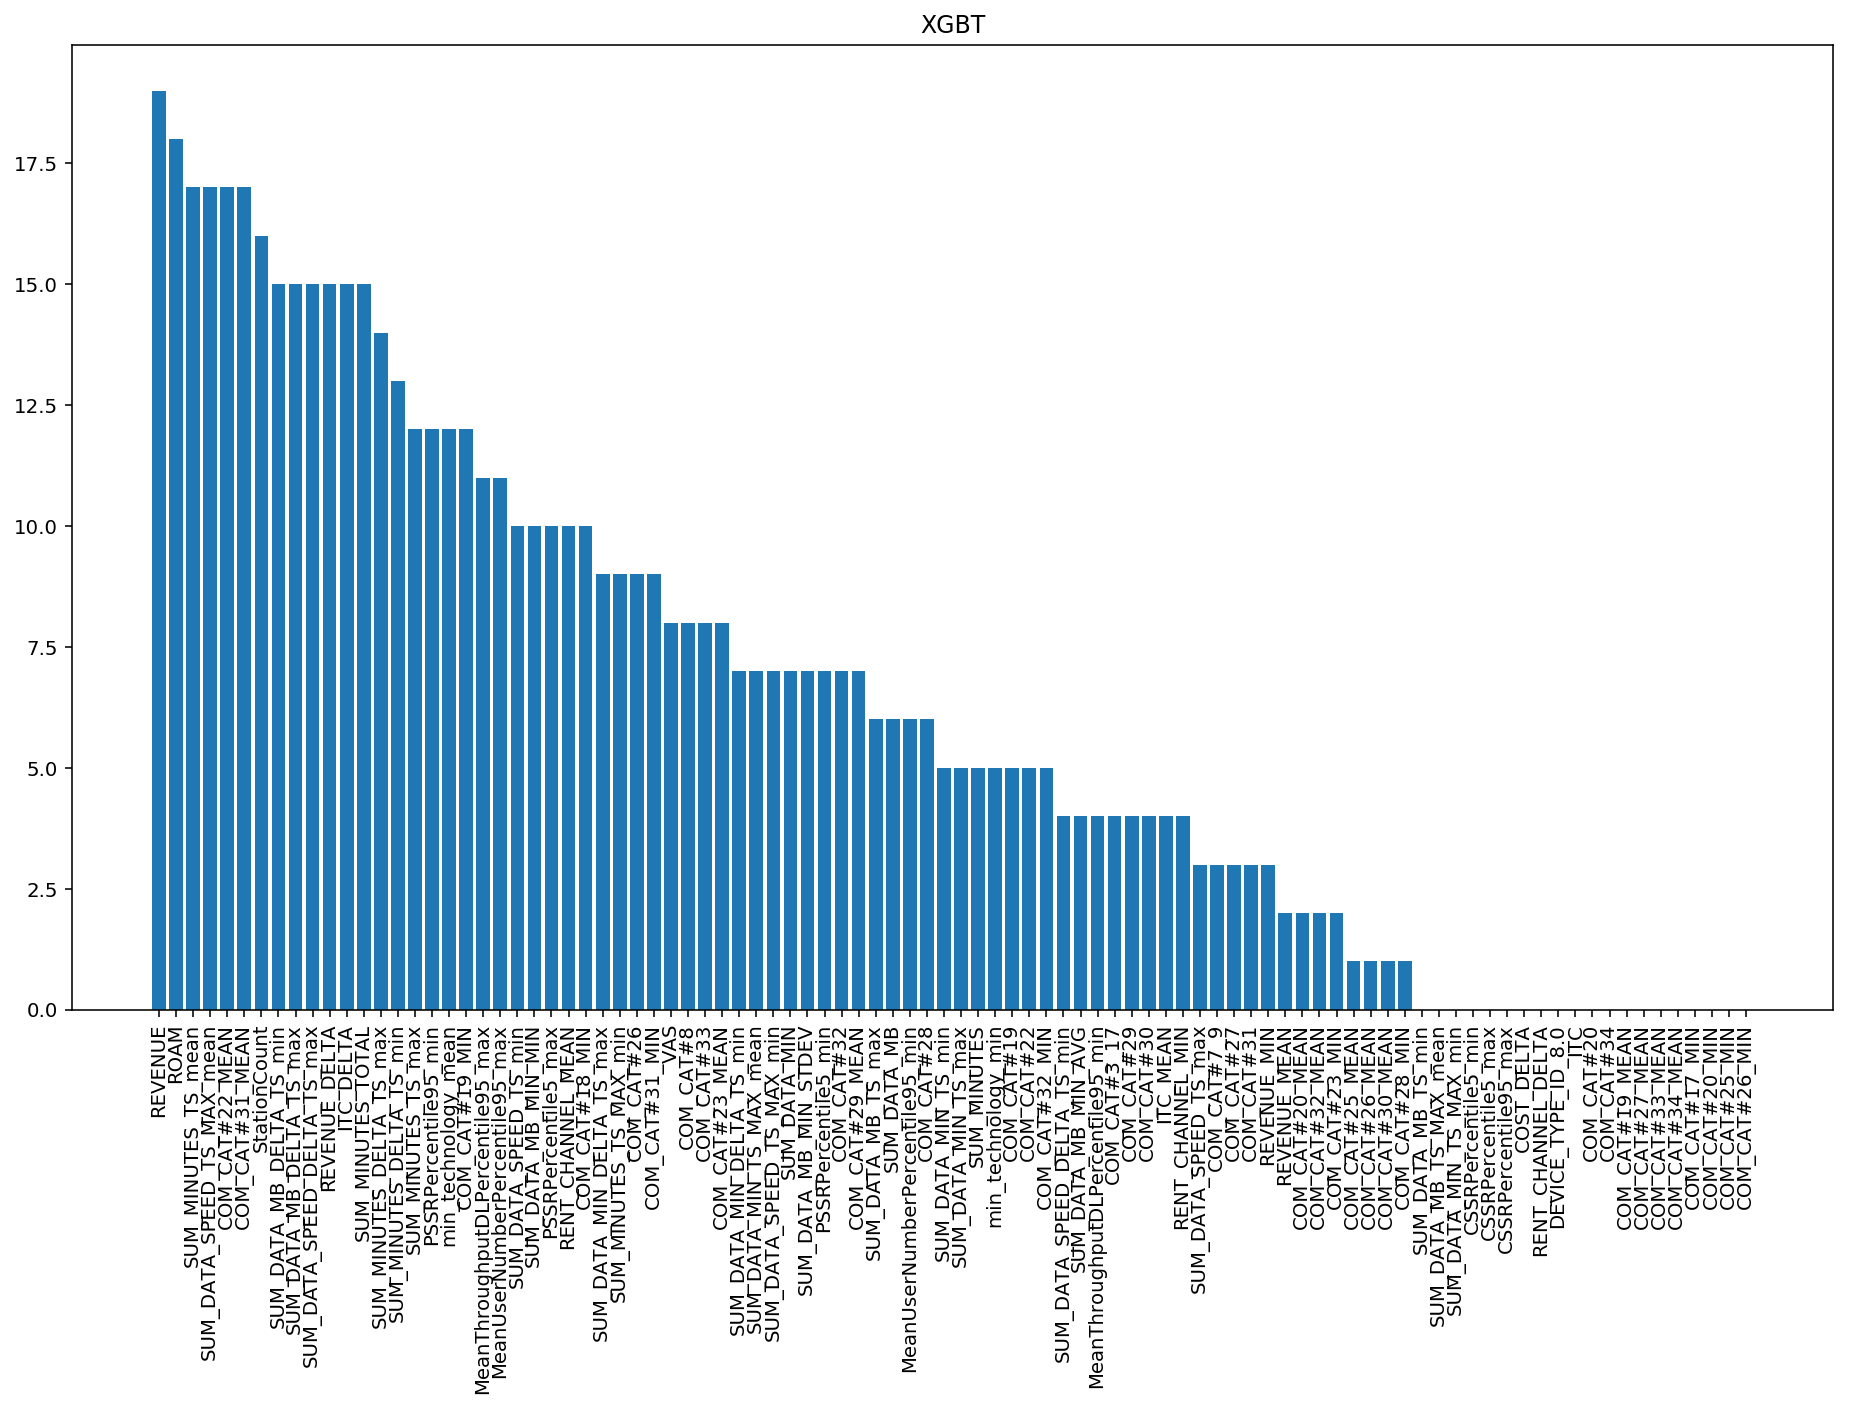

In [58]:
attr2 = dict(zip(indep.columns, gs1.feature_importances_))
attr2 = sorted(attr2.items(), key=lambda x: x[1], reverse = True)
x1,y1 = zip(*attr2)
i1=range(len(x1))
plt.figure(num=None, figsize=(16, 9), dpi=142, facecolor='w', edgecolor='k')
plt.bar(i1, y1)
plt.title("XGBT")
plt.xticks(i1, x1, rotation=90)
plt.show();

### Построение моделей

#### xgboost



In [ ]:
gs1 = GridSearchCV(xgb.XGBClassifier(),{'max_depth': range(2,30,2),
                    'n_estimators': range(50,200,5), 
                  'learning_rate': [0.1]}, n_jobs=3, scoring=make_scorer(roc_auc_score)) 
gs1.fit(indep_train, dep_train)
pd.DataFrame(gs1.best_estimator_.predict_proba(indep_result)[:,1]).to_csv(r"c:\work\dataset\gs1.csv", index=None, header=None)
roc_auc_score(y_true=dep_test, y_score=gs1.best_estimator_.predict_proba(indep_test)[:,1])

In [ ]:
#indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size=0.40, random_state=234)

#gs1 = xgb.XGBClassifier(max_depth= 8, n_estimators = 75, learning_rate =0.1, n_jobs=3) 
#gs1.fit(indep_train, dep_train)
#pd.DataFrame(gs1.predict_proba(indep_result)[:,1]).to_csv(r"c:\work\dataset\gs1_.csv", index=None, header=None)
#print(i, roc_auc_score(y_true=dep_test, y_score=gs1.predict_proba(indep_test)[:,1]), cross_val_score(gs1, indep_test, dep_test, cv=5, scoring='roc_auc').mean(), cross_val_score(gs1, indep_train, dep_train, cv=5, scoring='roc_auc').mean()) 

In [ ]:
gs1.best_params_

In [ ]:
cross_val_score(gs1.best_estimator_, indep_train, dep_train, cv=5, scoring='roc_auc').mean()

In [ ]:
cross_val_score(gs1.best_estimator_, indep_test, dep_test, cv=5, scoring='roc_auc').mean()

In [ ]:
attr2 = dict(zip(indep.columns, gs1.best_estimator_.feature_importances_))
attr2 = sorted(attr2.items(), key=lambda x: x[1], reverse = True)
x1,y1 = zip(*attr2)
i1=range(len(x1))
plt.figure(num=None, figsize=(16, 9), dpi=72, facecolor='w', edgecolor='k')
plt.bar(i1, y1)
plt.title("XGBT")
plt.xticks(i1, x1, rotation=90)
plt.show();

#### LightGBM

Единственная модель, использованная в отправке

In [ ]:
lgb_train = lgb.Dataset(indep_train, dep_train, categorical_feature=categorial, free_raw_data=False)
lgb_eval = lgb.Dataset(indep_test, dep_test, reference=lgb_train, free_raw_data=False)
gs4=lgb.train({'num_leaves':20, 'num_trees':95, 'min_data_in_leaf':20}, lgb_train, valid_sets=lgb_eval)
gs4.best_estimator_ = gs4
pd.DataFrame(gs4.predict(indep_result)).to_csv(r"c:\work\dataset\gs4.csv", index=None, header=None)
roc_auc_score(y_true=dep_test, y_score=gs4.best_estimator_.predict(indep_test))

In [ ]:
#gs42 = lgb.LGBMClassifier(num_leaves =7, num_trees = 99, min_data_in_leaf = 103, n_jobs=3) 
#gs42.fit(indep_train, dep_train)
#pd.DataFrame(gs42.predict_proba(indep_result)[:,1]).to_csv(r"c:\work\dataset\gs42.csv", index=None, header=None)
#print(i, roc_auc_score(y_true=dep_test, y_score=gs42.predict_proba(indep_test)[:,1]), cross_val_score(gs42, indep_test, dep_test, cv=5, scoring='roc_auc').mean(), cross_val_score(gs42, indep_train, dep_train, cv=5, scoring='roc_auc').mean())

Точный подбор параметров

In [39]:
for i in range (2,200,1):
    
    l = lgb.LGBMClassifier(num_leaves = 7, num_trees = 100, min_data_in_leaf = i, n_jobs=3)
    l.fit(indep_train, dep_train)
    print (i, j, cross_val_score(l, indep_test, dep_test, cv=5, scoring='roc_auc').mean(), roc_auc_score(y_true=dep_test, y_score=l.predict_proba(indep_test)[:,1]), cross_val_score(l, indep_train, dep_train, cv=5, scoring='roc_auc').mean())

2 10 0.549543592888 0.557775794889 0.525287842549
3 10 0.548283288273 0.554591382784 0.53545656463
4 10 0.543988032993 0.570417565785 0.522537679114
5 10 0.547492326359 0.54709631728 0.521462632895
6 10 0.54190825414 0.570634888168 0.521685742171
7 10 0.577764977798 0.56188318794 0.509809821267
8 10 0.552935716515 0.551335382129 0.517072445264
9 10 0.543975317092 0.56681640605 0.519286021237
10 10 0.540410272508 0.56028395087 0.528851192515
11 10 0.559671134319 0.576402879905 0.532123089302
12 10 0.53766038813 0.537181303116 0.530327986967
13 10 0.56841274669 0.554464824455 0.526283170182
14 10 0.571100940886 0.559068223888 0.532309113095
15 10 0.558019269781 0.5677508923 0.52792381423
16 10 0.561779511745 0.563538673157 0.530048624123
17 10 0.55923133241 0.562913551713 0.518036545527
18 10 0.563722276521 0.55886112844 0.515483960806
19 10 0.57918564532 0.562276924965 0.519613855228
20 10 0.570890218846 0.559181998548 0.523745992402
21 10 0.572428593886 0.548831061249 0.525470694002
22

163 10 0.546627845252 0.552666162138 0.527828843949
164 10 0.551163063937 0.551587220421 0.531185020935
165 10 0.545305936702 0.556928237592 0.530223321321
166 10 0.550961362147 0.556102412534 0.530500723129
167 10 0.545689421848 0.566232192348 0.5291304482
168 10 0.544646189086 0.548171423896 0.527296071398
169 10 0.55272316211 0.55638621 0.523806539875
170 10 0.550830212942 0.561366727687 0.525341830646
171 10 0.538700382519 0.564069195447 0.53324969192
172 10 0.547179548392 0.557263169736 0.536764438209
173 10 0.546441757626 0.562420102065 0.539616627334
174 10 0.550091899805 0.565155807365 0.533571786694
175 10 0.551352516866 0.553144271382 0.532838313071
176 10 0.552339955236 0.556189341488 0.521020406842
177 10 0.549788441516 0.564887350303 0.530875101313
178 10 0.553406499397 0.55430247185 0.527336123614
179 10 0.557188804604 0.557518843129 0.534836125224
180 10 0.544503121368 0.553619823892 0.534506831531
181 10 0.558247562026 0.554489113427 0.529903401898
182 10 0.546244270603

In [30]:
#gs42 = GridSearchCV(lgb.LGBMClassifier(),
#                   {  'num_leaves': range(2,30,1), 'num_trees': range(50,150,1), 'min_data_in_leaf':[20]}, 
##                   n_jobs=3, scoring=make_scorer(roc_auc_score)) 
#gs42.fit(indep_train, dep_train)
#pd.DataFrame(gs42.best_estimator_.predict_proba(indep_result)[:,1]).to_csv(r"c:\work\dataset\gs42.csv", index=None, header=None)
#roc_auc_score(y_true=dep_test, y_score=gs42.best_estimator_.predict_proba(indep_test)[:,1])

Проверка подобранных значений

In [42]:
l = lgb.LGBMClassifier(num_leaves = 7, num_trees = 100, min_data_in_leaf = 103, n_jobs=3)
l.fit(indep_train, dep_train)
pd.DataFrame(l.predict_proba(indep_result)[:,1]).to_csv(r"c:\work\dataset\gs42_ht.csv", index=None, header=None)
print (cross_val_score(l, indep_test, dep_test, cv=5, scoring='roc_auc').mean(), roc_auc_score(y_true=dep_test, y_score=l.predict_proba(indep_test)[:,1]))
        

0.576914739021 0.582999253434


Отправленный финальный вариант

In [ ]:
attr2 = dict(zip(indep.columns, l.feature_importances_))
attr2 = sorted(attr2.items(), key=lambda x: x[1], reverse = True)
x1,y1 = zip(*attr2)
i1=range(len(x1))
plt.figure(num=None, figsize=(16, 9), dpi=72, facecolor='w', edgecolor='k')
plt.bar(i1, y1)
plt.title("LightGBM")
plt.xticks(i1, x1, rotation=90)
plt.show();

#### SVM
(в финале не использовано)

In [ ]:

gs3 = GridSearchCV(SVC(),{'C': [0.1, 1, 10, 20], 'kernel' :['rbf'], 'probability' : [True]}, n_jobs=6, scoring=make_scorer(roc_auc_score)) 

gs3.fit(indep_train, dep_train)
pd.DataFrame(gs3.predict_proba(indep_result)[:,1]).to_csv(r"c:\work\dataset\gs3.csv", index=None, header=None)
roc_auc_score(y_true=dep_test, y_score=gs3.best_estimator_.predict_proba(indep_test)[:,1])

In [ ]:
gs3.best_params_

In [ ]:
cross_val_score(gs3.best_estimator_, indep_test, dep_test, cv=5, scoring='roc_auc').mean()

#### Random Forest
(в финале не использовано)

In [ ]:

gs2 = GridSearchCV(RandomForestClassifier(),{'n_estimators': [10, 100, 1000]}, n_jobs=6, scoring=make_scorer(roc_auc_score)) 
gs2.fit(indep_train, dep_train)
pd.DataFrame(gs2.predict_proba(indep_result)[:,1]).to_csv(r"c:\work\dataset\gs2.csv", index=None, header=None)
roc_auc_score(y_true=dep_test, y_score=gs2.best_estimator_.predict_proba(indep_test)[:,1])

In [ ]:
gs2.best_params_

In [ ]:
cross_val_score(gs3.best_estimator_, indep_train, dep_train, cv=5, scoring='roc_auc').mean()

In [ ]:
cross_val_score(gs2.best_estimator_, indep_train, dep_train, cv=5, scoring='roc_auc').mean()

In [ ]:
cross_val_score(gs2.best_estimator_, indep_test, dep_test, cv=5, scoring='roc_auc').mean()

In [ ]:
attr2 = dict(zip(indep.columns, gs2.best_estimator_.feature_importances_))
attr2 = sorted(attr2.items(), key=lambda x: x[1], reverse = True)
x1,y1 = zip(*attr2)
i1=range(len(x1))
plt.figure(num=None, figsize=(16, 9), dpi=72, facecolor='w', edgecolor='k')
plt.bar(i1, y1)
plt.title("RandomForest")
plt.xticks(i1, x1, rotation=90)
plt.show();

### Объединение моделей 
(в финале не использовано)

In [ ]:
r1 = pd.DataFrame(gs1.predict_proba(indep_train)[:,1])
r2 = pd.DataFrame(gs3.predict_proba(indep_train)[:,1])
r3 = pd.DataFrame(gs4.predict(indep_train))
r4 = pd.DataFrame(gs42.predict_proba(indep_train)[:,1])

rt1 = pd.DataFrame(gs1.predict_proba(indep_test)[:,1])
rt2 = pd.DataFrame(gs3.predict_proba(indep_test)[:,1])
rt3 = pd.DataFrame(gs4.predict(indep_test))
rt4 = pd.DataFrame(gs42.predict_proba(indep_test)[:,1])

rtp1 = pd.DataFrame(gs1.predict(indep_test))
rtp2 = pd.DataFrame(gs3.predict(indep_test))
rtp3 = pd.DataFrame(gs4.predict(indep_test))
rtp4 = pd.DataFrame(gs42.predict(indep_test))

rr1 = pd.DataFrame(gs1.predict_proba(indep_result)[:,1])
rr2 = pd.DataFrame(gs3.predict_proba(indep_result)[:,1])
rr3 = pd.DataFrame(gs4.predict(indep_result))
rr4 = pd.DataFrame(gs42.predict_proba(indep_result)[:,1])

rp1 = pd.DataFrame(gs1.predict(indep_result))
rp2 = pd.DataFrame(gs3.predict(indep_result))
rp3 = pd.DataFrame(gs4.predict(indep_result))
rp4 = pd.DataFrame(gs42.predict(indep_result))

indepl2 = pd.concat([r1, r2, r3, r4], axis=1)
indepl2.columns=["r1", "r2", "r3", "r4"]

testl2 = pd.concat([rt1, rt2, rt3, rt4], axis=1)
testl2.columns=["r1", "r2", "r3", "r4"]

resl2 = pd.concat([rr1, rr2, rr3, rr4], axis=1)
resl2.columns=["r1", "r2", "r3", "r4"]

rpl2 = pd.concat([rp1, rp2, rp3, rp4], axis=1)
rpl2.columns=["r1", "r2", "r3", "r4"]

rtpl2 = pd.concat([rtp1, rtp2, rtp3, rtp4], axis=1)
rpl2.columns=["r1", "r2", "r3", "r4"]

In [ ]:
q = (rt1+rt2+rt3+rt4)/4
roc_auc_score(y_true=dep_test, y_score=q)


In [ ]:
qr = (rr1+rr2+rr3+rr4)
pd.DataFrame(qr).to_csv(r"c:\work\dataset\gsl2_blend.csv", index=None, header=None)

In [ ]:
indep_columns = indepl2.columns
indep_result_columns = resl2.columns
indep_index = indepl2.index
indep_result_index = resl2.index

rs = StandardScaler()

indepl2 =  pd.DataFrame(rs.fit_transform(indepl2))
resl2 = pd.DataFrame(rs.fit_transform(resl2))

indepl2.columns = indep_columns
resl2.columns = indep_result_columns
indepl2.index = indep_index
resl2.index = indep_result_index

In [ ]:
gsl2 = lgb.LGBMClassifier()
gsl2.fit(indepl2, dep_train)
pd.DataFrame(gsl2.predict_proba(resl2)[:,1]).to_csv(r"c:\work\dataset\gsl2_stack.csv", index=None, header=None)
roc_auc_score(y_true=dep_test, y_score=gsl2.predict_proba(testl2)[:,1])

In [ ]:
cross_val_score(gsl2, testl2, dep_test, cv=5, scoring='roc_auc').mean()

In [ ]:
r = pd.DataFrame()
r["result"] = gsl2.predict_proba(resl2)[:,1]
r["SK_ID_CHECK"] = common_test["SK_ID"]

#r = r.groupby("SK_ID_CHECK", as_index=False).max()
r.head(20)

In [ ]:
resl2.describe()

In [ ]:
r["result"].fillna(0, inplace=True)
r.describe()

In [ ]:
uss_columns = r.columns
uss_index = r.index

imp = Imputer(strategy="most_frequent" )

cs = pd.DataFrame(imp.fit_transform(r))
cs.columns = uss_columns
cs.index = uss_index

In [ ]:
cs2 = cs.loc[:,["result"]]
cs2.shape

In [ ]:
cs2.describe()

In [ ]:
cs2.to_csv(r"c:\work\dataset\result.csv", index=None, header=None)
cs.to_csv(r"c:\work\dataset\result_test.csv", index=None, header=None)

In [ ]:
attr1 = dict(zip(["XGBoost", "SVC", "LGB train", "LGB fit"], gsl2.feature_importances_))
attr1 = sorted(attr1.items(), key=lambda x: x[1], reverse = True)

In [ ]:
x1,y1 = zip(*attr1)
i1=range(len(x1))

In [ ]:
plt.figure(num=None, figsize=(16, 9), dpi=72, facecolor='w', edgecolor='k')
plt.bar(i1, y1)
plt.title("LGB Level 2")
plt.xticks(i1, x1, rotation=90)
plt.show();